In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data=pd.read_csv(r'/content/drive/MyDrive/Data_sets/Raw-GPS-data-Kandy-Buses/preprocessed-data-digana_2021_10/clearn_gps_data_with_trip_id.csv')

In [4]:
data.head()

,id,deviceid,devicetime,latitude,longitude,speed,date,time,trip_id
0,574670748,116,2021-10-16 07:08:31,7.299052,80.734410,7.01944,2021-10-16,07:08:31,1.0
1,574670749,116,2021-10-16 07:08:46,7.298598,80.733327,19.43850,2021-10-16,07:08:46,1.0
2,574670750,116,2021-10-16 07:09:01,7.297437,80.732405,26.45790,2021-10-16,07:09:01,1.0
3,574670751,116,2021-10-16 07:09:07,7.297405,80.731912,5.93953,2021-10-16,07:09:07,1.0
4,574670752,116,2021-10-16 07:09:22,7.297420,80.731760,11.33910,2021-10-16,07:09:22,1.0


**scale-time**

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta

In [6]:
def reference_time(input_time):# Your input time in "YYYY-MM-DD HH:MM:SS" format
  # Example: Get the date of Monday for a given date
  # Convert the input date to a datetime object
  date_obj = datetime.strptime(input_time, "%Y-%m-%d %H:%M:%S")

  # Find the day of the week (Monday = 0, Tuesday = 1, ..., Sunday = 6)
  day_of_week = date_obj.weekday()

  # Calculate the number of days to subtract to get to the previous Monday
  days_to_subtract = day_of_week

  # Subtract the number of days to get the previous Monday
  previous_monday = date_obj - timedelta(days=days_to_subtract)

  # Format the previous Monday date as a string
  previous_monday = previous_monday.replace(hour=0, minute=0,second
                                                =0)
  previous_monday_str = previous_monday.strftime("%Y-%m-%d %H:%M:%S")
  # Print the previous Monday date
  # print(previous_monday_str)
  return previous_monday
reference_time("2023-06-22 03:05:30")

datetime.datetime(2023, 6, 19, 0, 0)

In [7]:

# Convert time values to seconds since the reference time
time_in_seconds = [(datetime.strptime(row['devicetime'], "%Y-%m-%d %H:%M:%S") - reference_time(row['devicetime'])).total_seconds()
                   for index,row in data.iterrows()]
time_array = [[time] for time in time_in_seconds]
print(time_array)
scaler = StandardScaler()
scaled_time = scaler.fit_transform(time_array)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
data['scaled_time']=scaled_time
data.head()

,id,deviceid,devicetime,latitude,longitude,speed,date,time,trip_id,scaled_time
0,574670748,116,2021-10-16 07:08:31,7.299052,80.734410,7.01944,2021-10-16,07:08:31,1.0,0.903802
1,574670749,116,2021-10-16 07:08:46,7.298598,80.733327,19.43850,2021-10-16,07:08:46,1.0,0.903887
2,574670750,116,2021-10-16 07:09:01,7.297437,80.732405,26.45790,2021-10-16,07:09:01,1.0,0.903973
3,574670751,116,2021-10-16 07:09:07,7.297405,80.731912,5.93953,2021-10-16,07:09:07,1.0,0.904007
4,574670752,116,2021-10-16 07:09:22,7.297420,80.731760,11.33910,2021-10-16,07:09:22,1.0,0.904092


**scale-GPS-data**

In [9]:
!pip install utm

  Preparing metadata (setup.py) ... done
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6085 sha256=b14d509d248eafb81bdecda236a3fd8a8275abcc1948d3dd9a0dde51ebd94759
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm


In [10]:
from sklearn.preprocessing import StandardScaler
import utm

In [11]:
coordinates = [[row['latitude'], row['longitude']] for index,row in data.iterrows()]
utm_coordinates = []
for lat, lon in coordinates:
   [utm_east, utm_north, utm_zone, utm_letter] = utm.from_latlon(lat, lon)#[464056.36598958017, 800282.7156244798,44,'N']
   utm_coordinates.append([utm_east, utm_north])
scaler = StandardScaler()
scaled_coordinates = scaler.fit_transform(utm_coordinates)

**cluster with only time scale**

In [12]:
new_data=data.drop(['id','deviceid', 'devicetime','date','time','trip_id'], axis=1)

In [13]:
new_data.head()

,latitude,longitude,speed,scaled_time
0,7.299052,80.734410,7.01944,0.903802
1,7.298598,80.733327,19.43850,0.903887
2,7.297437,80.732405,26.45790,0.903973
3,7.297405,80.731912,5.93953,0.904007
4,7.297420,80.731760,11.33910,0.904092


**K-mean cluster**

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [15]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(new_data)
    wcss.append(kmeans.inertia_)

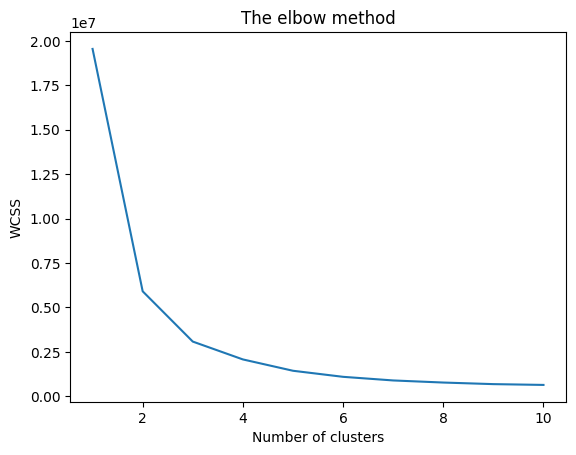

In [16]:
plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [17]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(new_data)

In [18]:
cluster_labels = kmeans.labels_
cluster_labels

array([0, 2, 2, ..., 1, 2, 0], dtype=int32)

In [19]:
y_kmeans

array([0, 2, 2, ..., 1, 2, 0], dtype=int32)

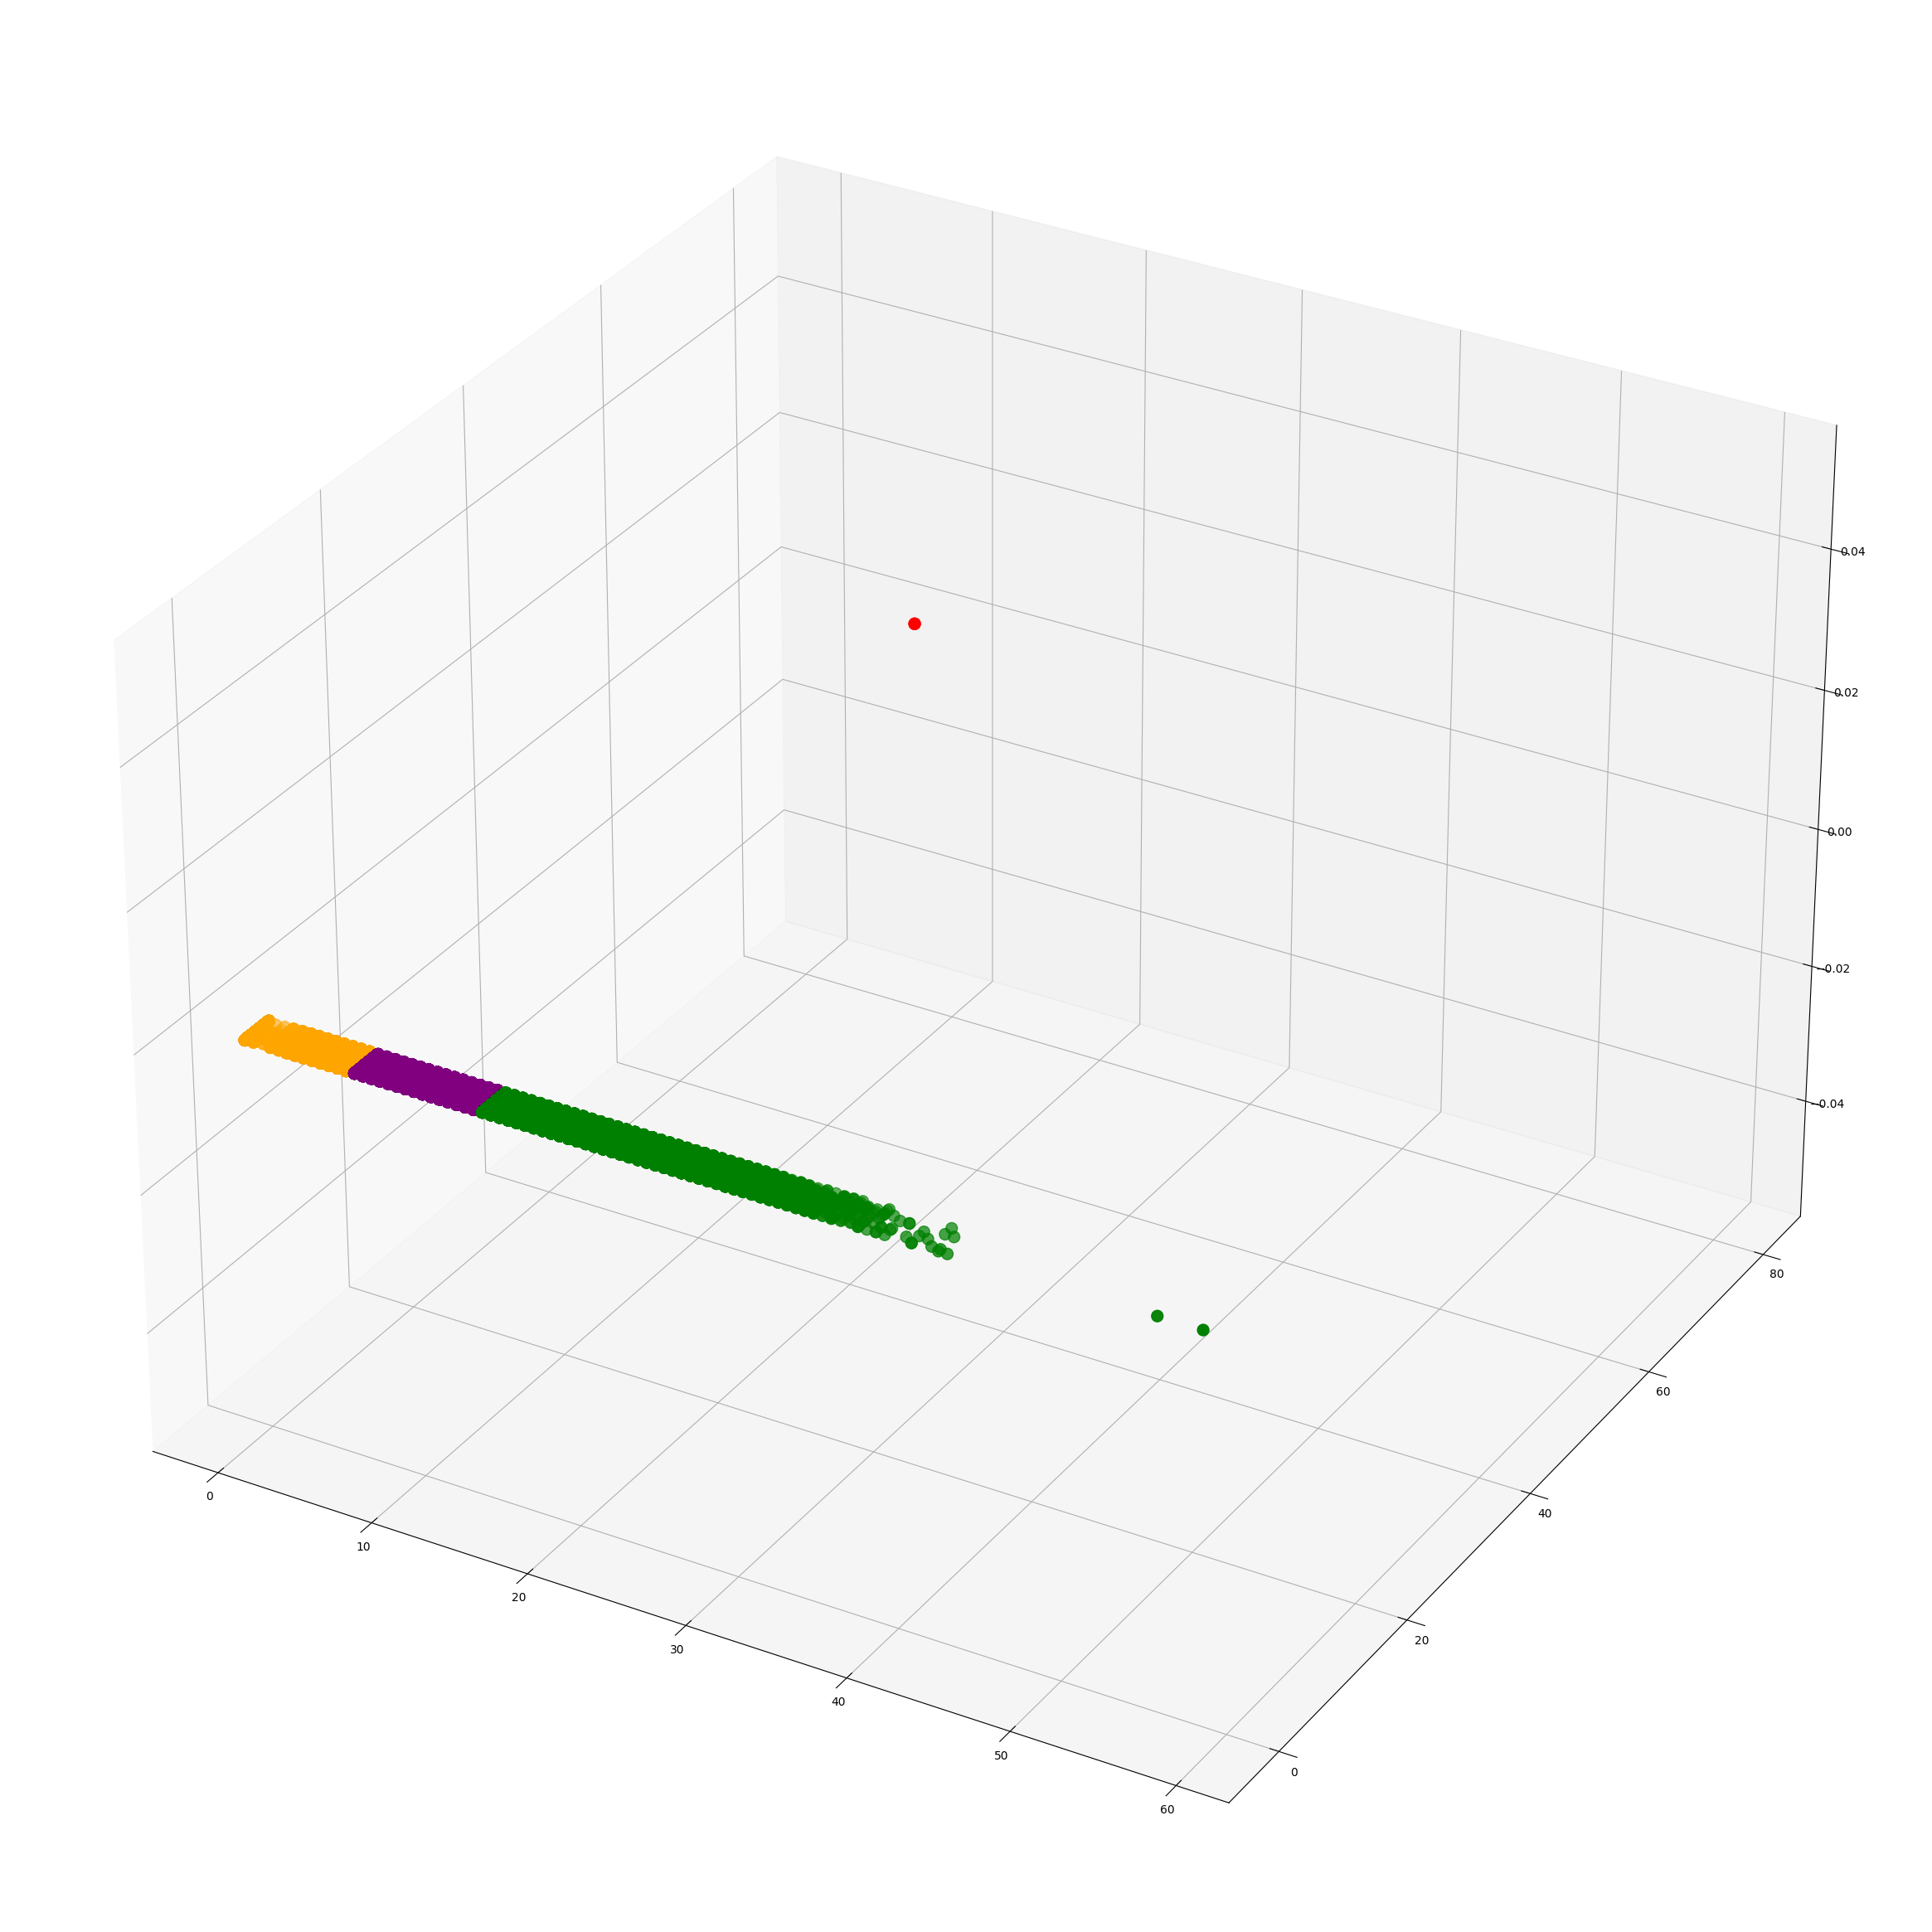

In [20]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (30,30))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(new_data.loc[y_kmeans == 0, 'speed'], new_data.loc[y_kmeans == 0, 'scaled_time'], s = 100, c = 'purple')
plt.scatter(new_data.loc[y_kmeans == 1, 'speed'], new_data.loc[y_kmeans == 1, 'scaled_time'], s = 100, c = 'orange')
plt.scatter(new_data.loc[y_kmeans == 2, 'speed'], new_data.loc[y_kmeans == 2, 'scaled_time'],s = 100, c = 'green')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 100, c = 'red', label = 'Centroids')

plt.show()

**cluster with scale time and scale GPS**

In [21]:
data['scaled_latitude']=scaled_coordinates[:,0]
data['scaled_longitude']=scaled_coordinates[:,1]
data.head()

,id,deviceid,devicetime,latitude,longitude,speed,date,time,trip_id,scaled_time,scaled_latitude,scaled_longitude
0,574670748,116,2021-10-16 07:08:31,7.299052,80.734410,7.01944,2021-10-16,07:08:31,1.0,0.903802,1.664706,1.867178
1,574670749,116,2021-10-16 07:08:46,7.298598,80.733327,19.43850,2021-10-16,07:08:46,1.0,0.903887,1.630372,1.793482
2,574670750,116,2021-10-16 07:09:01,7.297437,80.732405,26.45790,2021-10-16,07:09:01,1.0,0.903973,1.601151,1.604438
3,574670751,116,2021-10-16 07:09:07,7.297405,80.731912,5.93953,2021-10-16,07:09:07,1.0,0.904007,1.585518,1.599341
4,574670752,116,2021-10-16 07:09:22,7.297420,80.731760,11.33910,2021-10-16,07:09:22,1.0,0.904092,1.580715,1.601798


In [22]:
new_data_1=data.drop(['id','deviceid', 'devicetime','date','time','trip_id','latitude','longitude'], axis=1)
new_data_1.head()

,speed,scaled_time,scaled_latitude,scaled_longitude
0,7.01944,0.903802,1.664706,1.867178
1,19.43850,0.903887,1.630372,1.793482
2,26.45790,0.903973,1.601151,1.604438
3,5.93953,0.904007,1.585518,1.599341
4,11.33910,0.904092,1.580715,1.601798


In [23]:
wcss_1 = []

for i in range(1, 11):
    kmeans_1 = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans_1.fit(new_data_1)
    wcss_1.append(kmeans_1.inertia_)

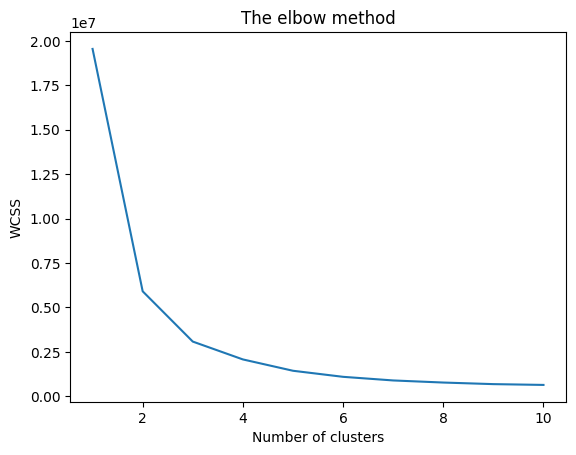

In [24]:
plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [25]:
kmeans_1 = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans_1 = kmeans_1.fit_predict(new_data_1)

In [26]:
cluster_labels_1 = kmeans_1.labels_
cluster_labels_1

array([0, 2, 2, ..., 1, 2, 0], dtype=int32)

In [27]:
new_data_1.loc[y_kmeans == 0, 'speed']

0          7.01944
4         11.33910
17        11.87910
23         7.55940
28         7.01944
            ...   
396729    11.33910
396730    11.33910
396732    11.87910
396734     8.09935
396737    12.41900
Name: speed, Length: 148823, dtype: float64

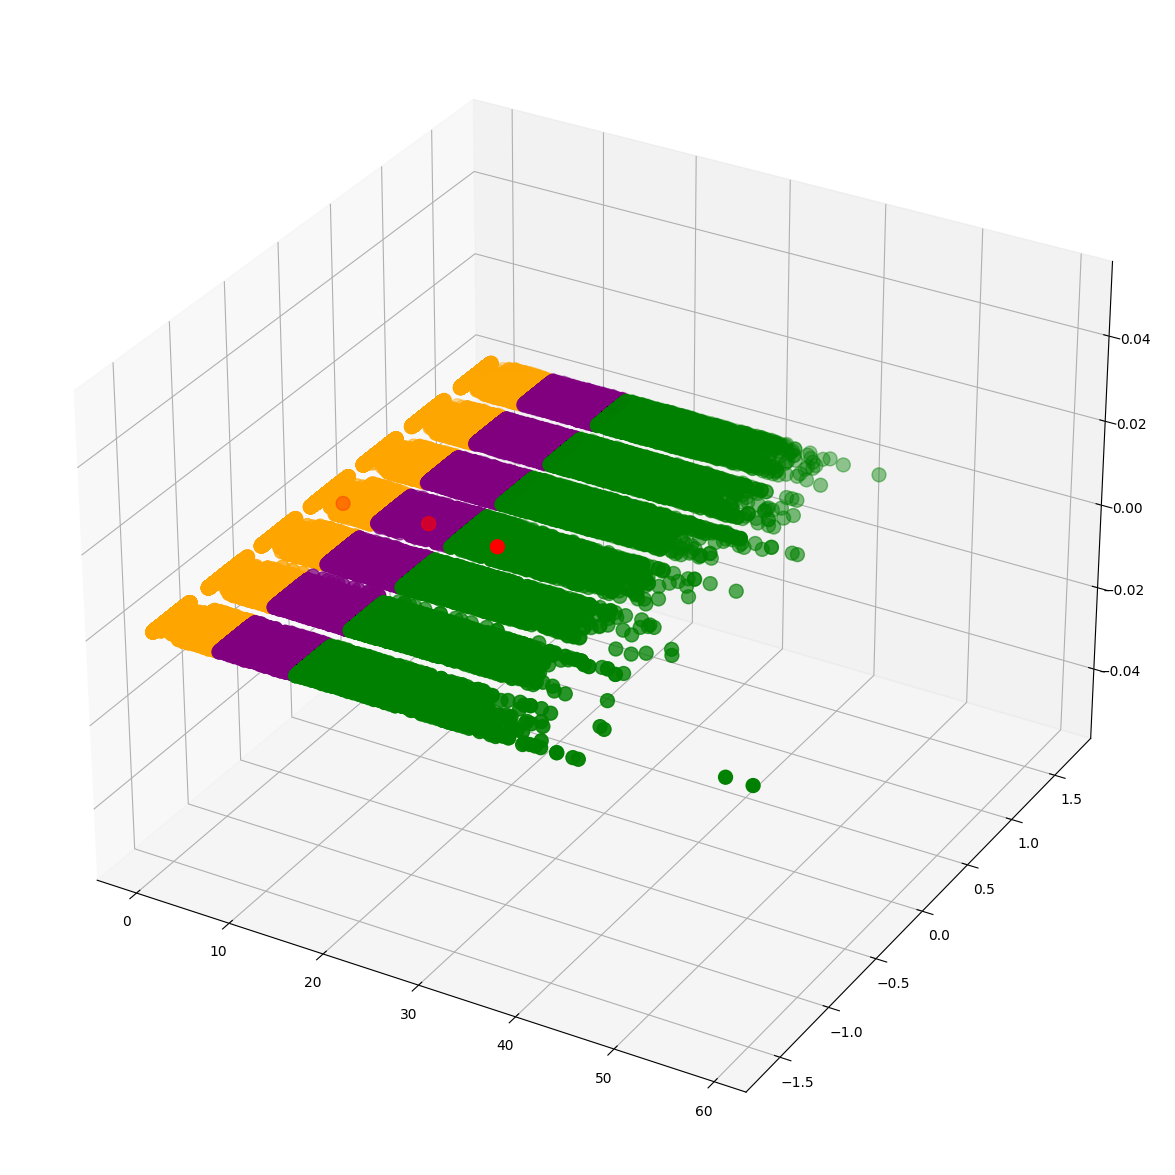

In [28]:
# 3d scatterplot using matplotlib

fig_1 = plt.figure(figsize = (15,15))
ax = fig_1.add_subplot(111, projection='3d')
plt.scatter(new_data_1.loc[y_kmeans_1 == 0, 'speed'], new_data_1.loc[y_kmeans_1 == 0, 'scaled_time'], s = 100, c = 'purple')
plt.scatter(new_data_1.loc[y_kmeans_1 == 1, 'speed'], new_data_1.loc[y_kmeans_1 == 1, 'scaled_time'], s = 100, c = 'orange')
plt.scatter(new_data_1.loc[y_kmeans_1 == 2, 'speed'], new_data_1.loc[y_kmeans_1 == 2, 'scaled_time'],s = 100, c = 'green')
plt.scatter(new_data_1.loc[y_kmeans_1 == 3, 'speed'], new_data_1.loc[y_kmeans_1 == 3, 'scaled_time'], s = 100, c = 'black')

#Plotting the centroids of the clusters
plt.scatter(kmeans_1.cluster_centers_[:, 0], kmeans_1.cluster_centers_[:,1], s = 100, c = 'red', label = 'Centroids')
plt.show()